In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
import ipywidgets

from SimPEG.EM import FDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

/Users/lindseyjh/git/python_symlinks/SimPEG/EM/Static/DC/IODC.py:13: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")


In [2]:
simDir = 'FDEM_Augustin_sigma'  # create a simulation directory where results can be saved. 

In [3]:
sigma_casing = [3e6, 1e7, 3e7, 1e8]

In [4]:
sigma_air = 1e-5
sigma_back = 1e-5
casing_t = 10e-3 # 10mm thick casing
casing_d = 100e-3 # 10cm diameter
casing_l = 2000

def get_model(sig_casing):
    model = casingSim.model.CasingInHalfspace(
        directory = simDir,
        sigma_air = sigma_air,
        sigma_casing = sig_casing,  # conductivity of the casing (S/m)
        sigma_back = sigma_back,  # conductivity of the background (S/m)
        sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
        casing_d = casing_d-casing_t,  # 135mm is outer casing diameter
        casing_l = casing_l,
        casing_t = casing_t, 
        mur_casing = 1,
        src_a = np.r_[0., 0., 0.],
        src_b = np.r_[0., 0., 0.]
    )
 
    return model

In [5]:
model_names = ["casing_{:1.0e}".format(sig) for sig in sigma_casing]

In [6]:
model_dict = {
    key: get_model(sig) for key, sig in zip(model_names, sigma_casing)
}

In [7]:
model_dict["baseline"] = model_dict[model_names[0]].copy()
model_dict["baseline"].sigma_casing = model_dict["baseline"].sigma_back
model_names = ["baseline"] + model_names
model_names

['baseline', 'casing_3e+06', 'casing_1e+07', 'casing_3e+07', 'casing_1e+08']

In [8]:
freqs = np.logspace(-2, 4, 60)
for mod in model_dict.values():
    mod.freqs = freqs

In [9]:
model_dict[model_names[0]].serialize()

{u'__class__': 'CasingInHalfspace',
 'casing_d': 0.09000000000000001,
 'casing_l': 2000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': u'FDEM_Augustin_sigma',
 'filename': u'ModelParameters.json',
 'freqs': [0.01,
  0.012638482029342977,
  0.01597312280060254,
  0.02018760254679039,
  0.025514065200312887,
  0.03224590545296395,
  0.040753929658717776,
  0.05150678076168125,
  0.0650967523045817,
  0.0822724134170047,
  0.103979841848149,
  0.13141473626117567,
  0.1660882782627716,
  0.20991037201085547,
  0.26529484644318974,
  0.3352924149249558,
  0.4237587160604063,
  0.5355666917706899,
  0.6768750009458534,
  0.8554672535565685,
  1.0811807510766078,
  1.3664483492953259,
  1.726983290659436,
  2.182644728397487,
  2.7585316176291843,
  3.4863652276780877,
  4.406236427773573,
  5.568813990945273,
  7.038135554931562,
  8.895134973108236,
  11.242100350620873,
  14.208308325339223,
  17.957144943716408,
  22.695105366946706,
  28.683168133420118,
  36.251170499885355,
 

In [10]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 100  # go out 500m from the well

# padding parameters
npadx, npadz = 20, 27  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4


# # theta discretization
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
# hy = np.r_[hy, hy]
# hy = hy*2*np.pi / hy.sum()


# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
def get_mesh(mod):
    return casingSim.CasingMeshGenerator(
        directory=simDir,  # directory where we can save things
        modelParameters=mod,  # casing parameters
        npadx=npadx,  # number of padding cells in the x-direction
        npadz=npadz,  # number of padding cells in the z-direction
        domain_x=domainx2,  # extent of the second uniform region of the mesh 
#         hy=hy,   # cell spacings in the 
        csx1=mod.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
        csx2=csx2,  # second core cell size
        csz=csz,  # cell size in the z-direction
        pfx2=pfx2,  # padding factor to "infinity"
        pfz=pfz  # padding factor to "infinity" for the z-direction
    )

In [11]:
mesh_generator = get_mesh(model_dict[model_names[0]])

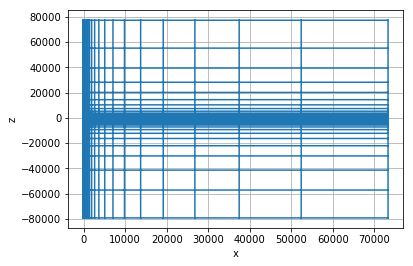

In [12]:
mesh_generator.mesh.plotGrid()

In [13]:
model_dict[model_names[0]].skin_depth().max()

1591549.4309189534

In [14]:
# Assign physical properties on the mesh
physpropsDict = {
    name: casingSim.model.PhysicalProperties(mesh_generator, mod) 
    for name, mod in model_dict.iteritems()
}

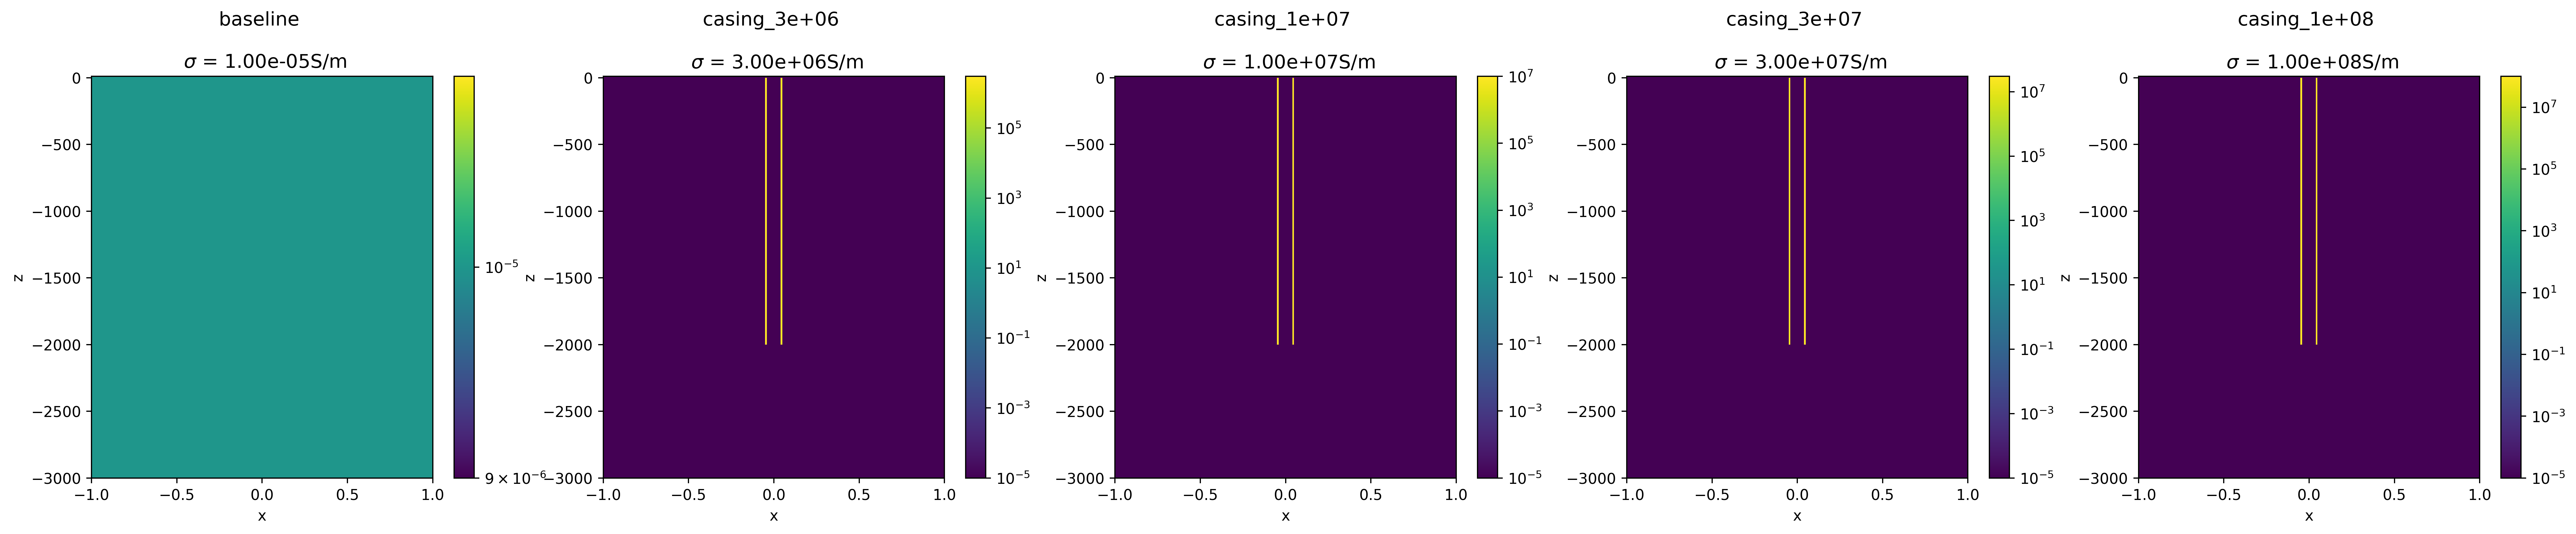

In [15]:
# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

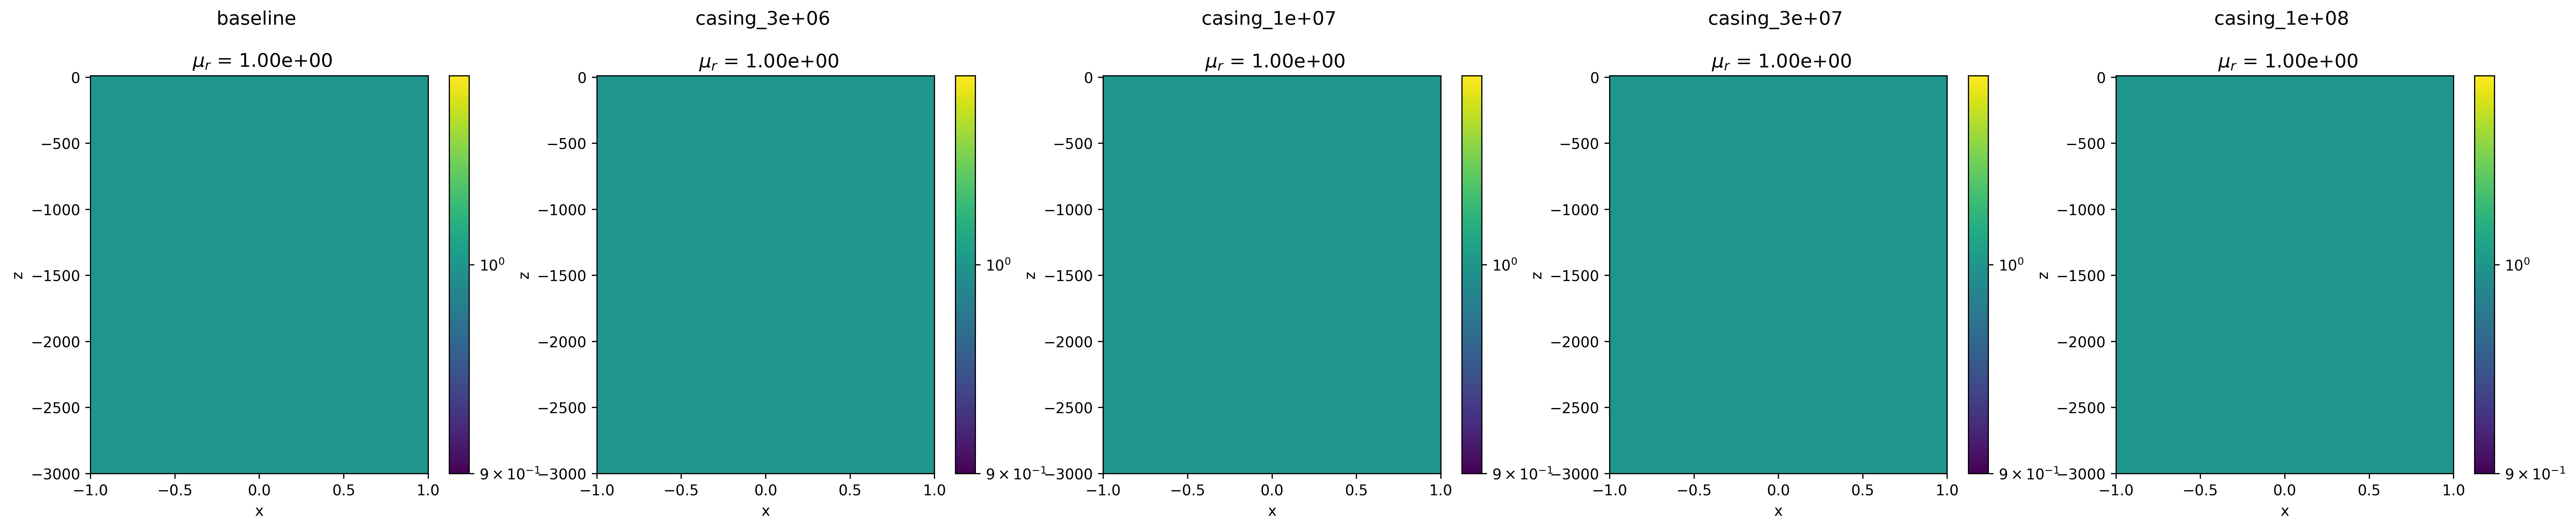

In [16]:
# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_mur(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\mu_r$ = {:1.2e}'.format(title, pp.modelParameters.mur_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

In [17]:
rx_loc = np.array([[0., 0., -500.]])

In [18]:
rx_re = FDEM.Rx.Point_bSecondary(rx_loc, orientation="z", component="real")
rx_im = FDEM.Rx.Point_bSecondary(rx_loc, orientation="z", component="imag")

In [19]:
loop_radius = 100
src_list = [FDEM.Src.CircularLoop(
    [rx_re, rx_im], f, np.r_[0., 0., 0.], orientation="z", moment=1, radius=100
) for f in freqs]

In [20]:
wires = physpropsDict[model_names[0]].wires
wires.sigma

In [21]:
prob = FDEM.Problem3D_e(mesh=mesh_generator.mesh, sigmaMap=wires.sigma, muMap=wires.mu)

In [22]:
survey = FDEM.Survey(src_list)
prob.pair(survey)

In [23]:
fields_dict = {}

In [24]:
import time

In [25]:
model_names

['baseline', 'casing_3e+06', 'casing_1e+07', 'casing_3e+07', 'casing_1e+08']

In [26]:
%%time
for key in model_names:
    t = time.time()
    print('--- Running {} ---'.format(key))
    fields_dict[key] = prob.fields(physpropsDict[key].model)
    print(" ... done. Elapsed time {}".format(time.time() - t))
    print('\n')

--- Running baseline ---
 ... done. Elapsed time 65.7450778484


--- Running casing_3e+06 ---
 ... done. Elapsed time 58.8545119762


--- Running casing_1e+07 ---
 ... done. Elapsed time 55.4435620308


--- Running casing_3e+07 ---
 ... done. Elapsed time 57.9798531532


--- Running casing_1e+08 ---
 ... done. Elapsed time 67.1312448978


CPU times: user 8min 27s, sys: 41.8 s, total: 9min 9s
Wall time: 5min 5s


In [27]:
for src in survey.srcList:
    src.rxList=[rx_re, rx_im]

In [28]:
data_dict = {}
for key in model_names:
    model = physpropsDict[key].model
    prob.model = model
    data_dict[key] = survey.dpred(model, f=fields_dict[key])

In [ ]:
real_response = 

(2.6547083457666105e-09, 1.054624684738545, -0.0059583646687221764, 0.53592581320627386)
(2.9442145319546868e-08, 1.0535013304981111, -0.0056010135996178347, 0.53624497688284145)
(2.648564140982758e-07, 1.0535473160257161, -0.005525345514758054, 0.53316623738935243)
(2.9423843658598485e-06, 1.0533449803537667, -0.0054964225707737433, 0.53476870807238774)


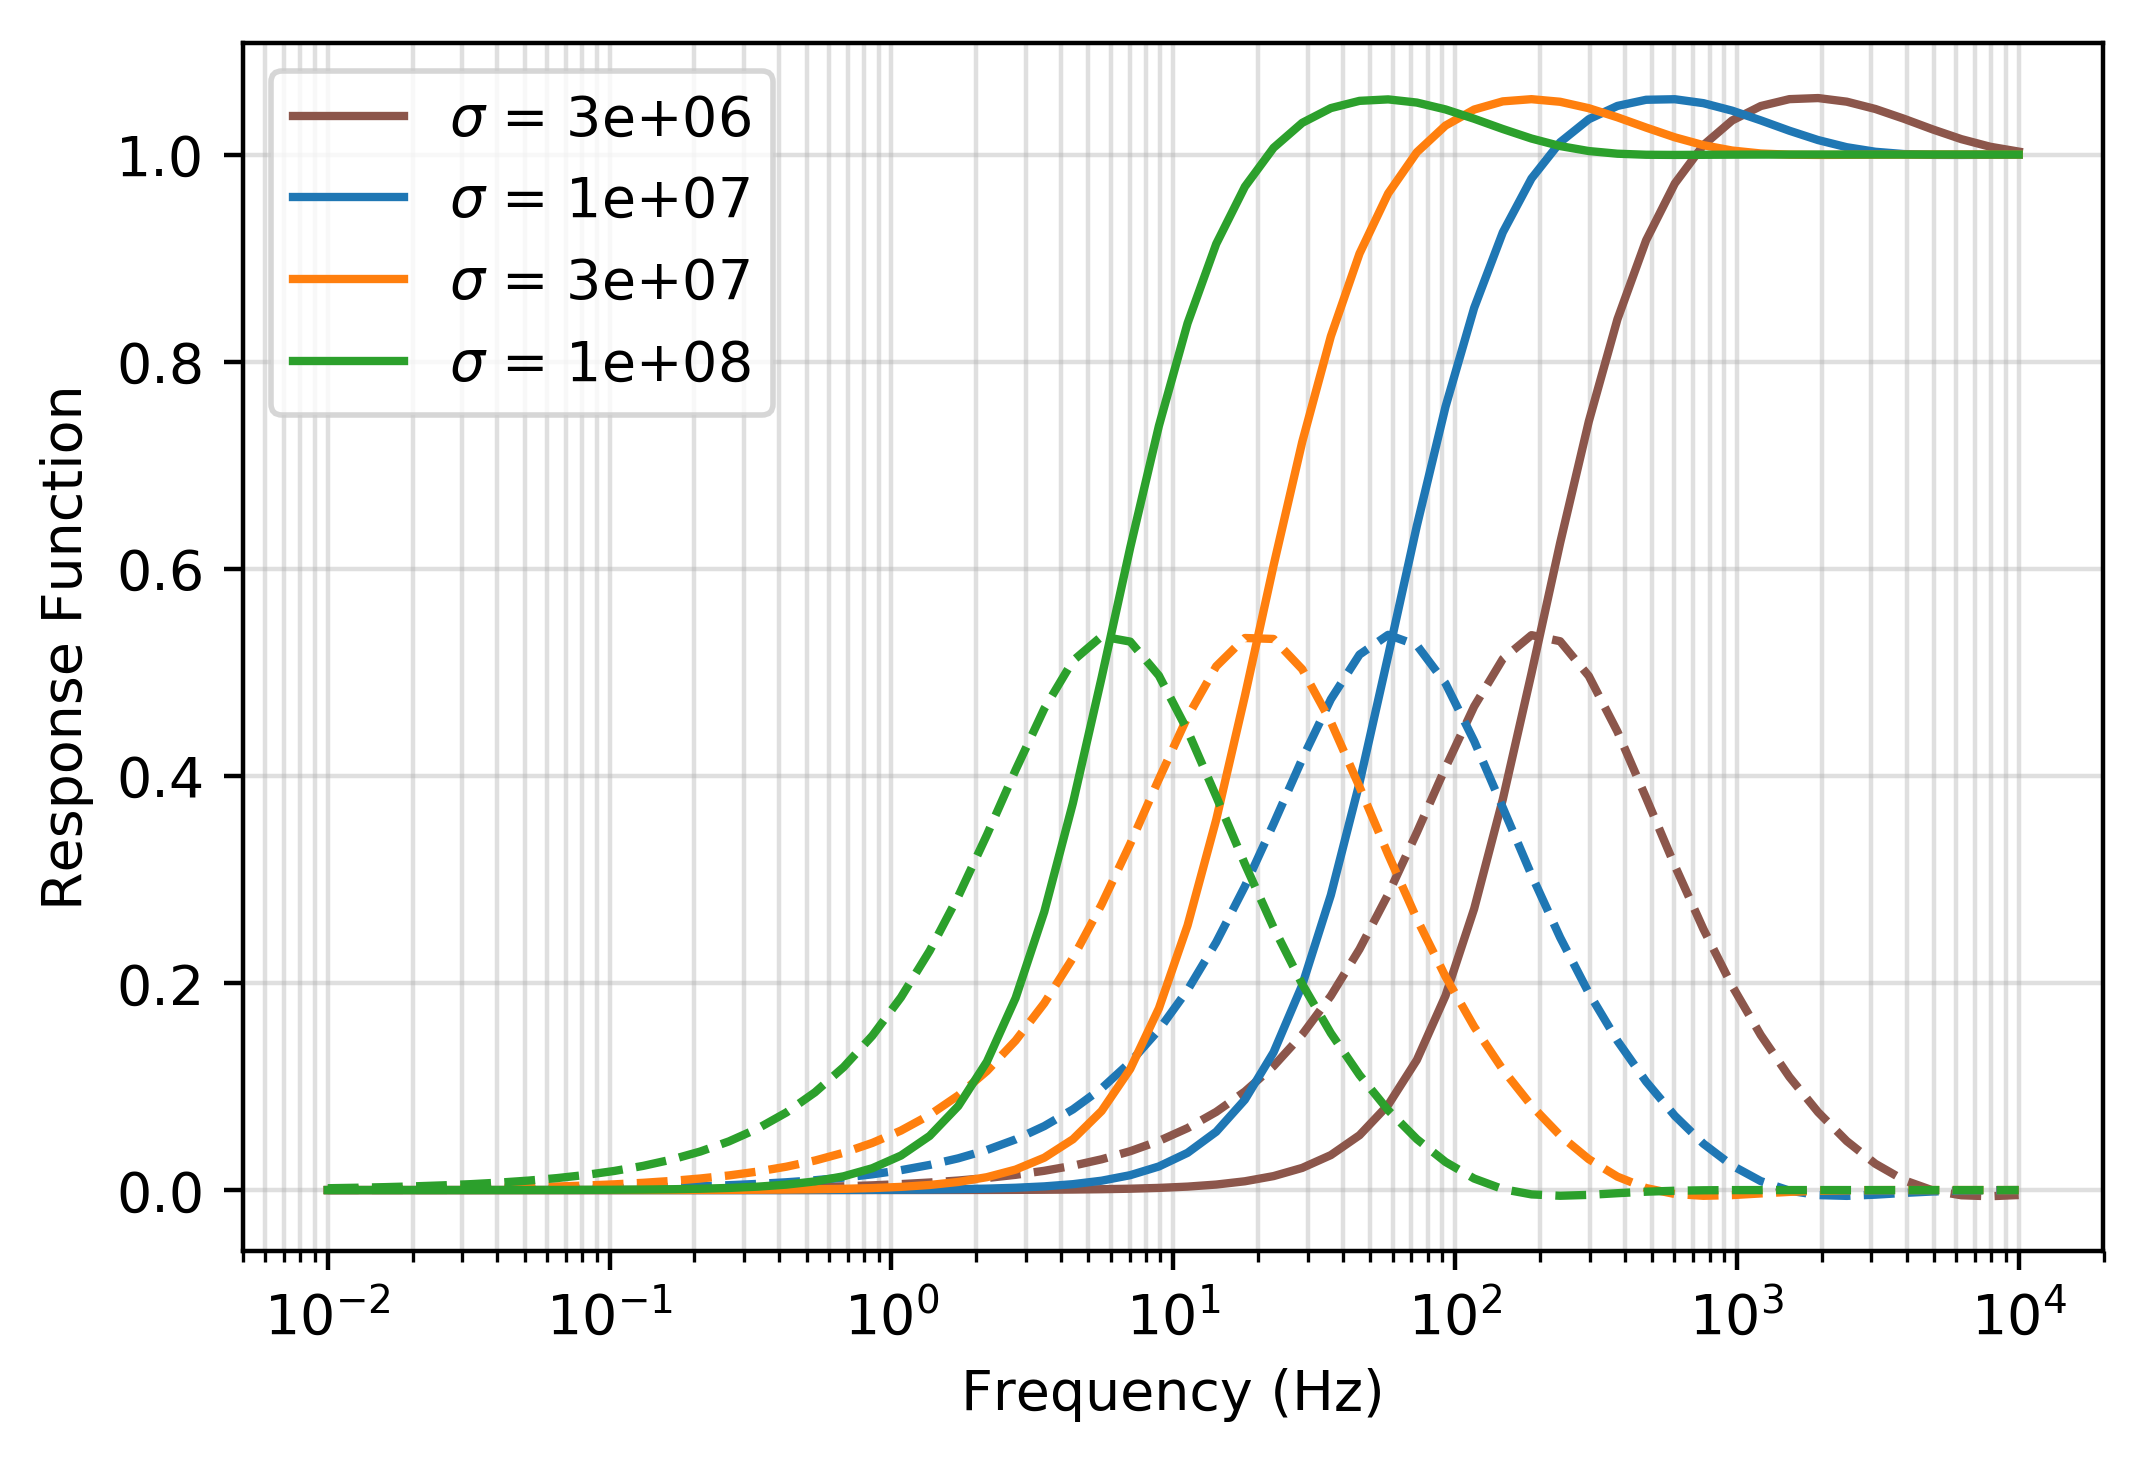

In [44]:
fig, ax = plt.subplots(1, 1, dpi=400)
for i, key in enumerate(model_names[1:]):
    bPrimary = rx_re.getP(mesh_generator.mesh, "Fx") * src_list[i].bPrimary(prob)
    data = (data_dict[key])
    prob.model = physpropsDict[key].model
    data_re = -data[0::2] / bPrimary
    data_im = -data[1::2] / bPrimary
    
    print(data_re.min(), data_re.max(), data_im.min(), data_im.max())
    label = "$\sigma$ = " + key.split("_")[-1]
    ax.semilogx(freqs, data_re, color="C{}".format(i-1 if i > 0 else 5), label=label)
    ax.semilogx(freqs, data_im, color="C{}".format(i-1 if i > 0 else 5), linestyle="--")
ax.legend()
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Response Function")
ax.grid(which='both', alpha=0.4)
# ax.set_ylim([-0.1, 0.1])
# ax.set_ylabel()
plt.show()

fig.savefig("augustin_response_function_sigma")

In [38]:
# Plot the charges
# mesh2D = cylMeshGen.create_2D_mesh().mesh
mesh = mesh_generator.mesh
theta_ind=0
background_key = 'casing_1'

def plotCasingResults(
    ax = None,
    clim_max=None, clim_min=None, 
    max_depth=1.1*model_dict[model_names[0]].casing_l, 
    max_r=0.1, top=10., view='charge', model='casing', 
    primsec=['total', 'primary', 'secondary'], 
    casing_outline=True, 
    component='real',
    src_ind=0
):
    if ax is None: 
        plt.subplots(1, 1, figsize=(5, 6))
        
    assert view.lower() in ['j', 'e', 'b', 'h']

    xlim = max_r*np.r_[-1, 1]  # x-limits in meters
    zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
    clim = None
    plotopts = {
        'theta_ind': theta_ind,
        'pcolorOpts':{'norm':LogNorm()}
    }
    
    if not clim_max is not None or clim_max != 0.:
        clim = clim_max * np.r_[-1, 1]
        plotopts['clim'] = clim

        if clim_min is not None or clim_min != 0.:
            plotopts['clim'][0] = clim_min
        
    if primsec == 'primary':
        model = background_key

    pp = physpropsDict[model]
    src = survey.srcList[src_ind]
    plotme = fields_dict[model][src, view]
    
    if primsec == 'secondary':
        prim_src = survey.srcList[src_ind]
        plotme = plotme - fields_dict[background_key][prim_src, view]

    if view in ['j', 'e']:
        plotme = mesh.aveE2CC * plotme
        _, cb = pp.plot_prop(
            np.absolute(getattr(plotme, component)),
            ax=ax,
            **plotopts 
        )
    elif view in ['b', 'h']:
        _, cb = casingSim.plotFace2D(
            mesh,
            plotme, real_or_imag=component, ax=ax, range_x=xlim,
            range_y=zlim, sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
            logScale=True, clim=clim, mirror=True
        )
    ax.set_title('$\sigma$ = {} \n {} {} {} \n f={:1.2f}Hz'.format(
        model.split("_")[-1], primsec, view, component, freqs[src_ind]), fontsize=13
    )
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
#         cb.set_label(view)
    cb.update_ticks()
        
    # plot outline of casing
    if casing_outline is True: 
        m = model_dict[model]
        factor = [-1, 1]
        [
            ax.plot(
                fact * np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
                np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
                'k', 
                lw = 0.5
            ) 
            for fact in factor
        ]
    return ax 
    

def plotCasingResultsWidget(
    clim_max=None, clim_min=None, 
    max_depth=1.1*model_dict[model_names[0]].casing_l, 
    max_r=0.1, top=10., view='charge', model='all', 
    primsec=['total', 'primary', 'secondary'],
    component='real',
    src_ind=0
):
    
    model_names = model_names if model == 'all' else [model]
    
    fig, ax = plt.subplots(1, len(model_names), figsize=(len(model_names)*5, 6))
    if len(model_names) == 1:
        ax = [ax]
    
    for a, mod in zip(ax, model_names): 
        a = plotCasingResults(
            ax = a,
            clim_max=clim_max, clim_min=clim_min, 
            max_depth=max_depth, 
            max_r=max_r, top=top, view=view, model=mod, 
            primsec=primsec, 
            casing_outline=True,
            component=component,
            src_ind=src_ind
        )
    
    plt.tight_layout()
    plt.show()

In [39]:
# fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=350)

ipywidgets.interact(
    plotCasingResultsWidget,
    clim_max = ipywidgets.FloatText(value=0),
    clim_min = ipywidgets.FloatText(value=0),
    max_depth = ipywidgets.FloatText(value=2100), 
    max_r = ipywidgets.FloatText(value=0.15),
    top = ipywidgets.FloatText(value=10),
    view = ipywidgets.ToggleButtons(
        options=['e', 'j', 'b', 'h'], value='b'
    ),
    model = ipywidgets.ToggleButtons(
        options=model_names, value=model_names[1]
    ),
    primsec = ipywidgets.ToggleButtons(
        options=['total', 'primary', 'secondary'], value='total'
    ), 
    component=ipywidgets.ToggleButtons(
        options=['real', 'imag'], value="real"
    ), 
    src_ind=ipywidgets.IntSlider(
        min=0, max=len(freqs)-1, value=0
    )
)   

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.plotCasingResultsWidget>

ValueError: values must all be positive

ValueError: values must all be positive

ValueError: values must all be positive

ValueError: minvalue must be less than or equal to maxvalue

ValueError: minvalue must be less than or equal to maxvalue

In [ ]:
P.shape

In [ ]:
src_list[i].bPrimary

In [ ]:
    data_re = data[0::2] / src_list[i].bPrimary